In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from chitaxi.datasets import loader, builder

# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# ChiTaxi 03 - Baseline Linear Regression

In this section, we are going to use the Linear Regression model as our benchmark.

We are going to use the features generated from 2015, to predict the each taxi's aggregated revenues in the next year, 2016.

## Load Data

In [2]:
loader.list_feathers()

2015_features.feather
Base_Xtest.feather
Base_Xtrain.feather
Base_Ytest.feather
Base_Ytrain.feather
clean_2015.feather
clean_2016.feather
data_2016.feather
labels_2016.feather


In [2]:
df_2015 = loader.read_feather("2015_features.feather")
df_2015.set_index('taxi_id', inplace=True)
df_2016 = loader.read_feather("labels_2016.feather")
df_2016.set_index('taxi_id', inplace=True)

/Users/liyiheng/.pyenv/versions/chitaxi/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
bd = builder.Builder()
data = bd.merge_data(df_2015, df_2016)

2018-09-25 11:32:00 - INFO - Merging features and labels...
2018-09-25 11:32:00 - INFO - We have 7155 unique ids in 2015
2018-09-25 11:32:00 - INFO - 746 of them (10.42628%) dropped (nan) in 2016


While loading the data, we noticed that not every taxi in 2015 is still working in 2016. In this analysis, we simply removed those uncontinuous data points. Alternatively, we could force them have 0 revenues in 2016, and to see if our model can capture those noises.

## Train Test Split

By performing the 0.2 size train test split, we replicated the distribution we observed in sections before.

In [4]:
X_train, X_test, y_train, y_test = bd.train_split(data, 'trip_total', seed=999, filename="Base")

Text(0.5, 1.0, 'Test Data')

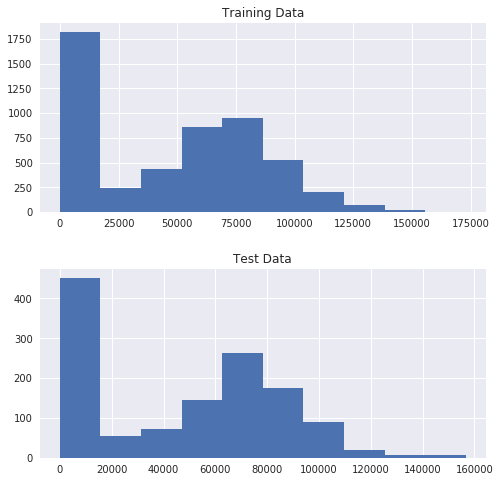

In [5]:
fig, ax = plt.subplots(2,1,figsize=(8,8))

y_train.hist(ax=ax[0])
ax[0].set_title("Training Data")
y_test.hist(ax=ax[1])
ax[1].set_title("Test Data")

## Baseline: Linear Regression

### Cross Validations

In the 3-fold cross validations on the training data, we plotted the RMSE as the main metric to evaluate if our model is working. The black bar indicates the lowest/highest volatile scores.

> Note: Test here means in-sample test data in each CV validate fold.

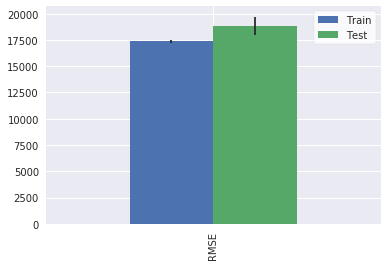

In [7]:
lin_reg = LinearRegression()
score_MSE = {'MSE':make_scorer(mean_squared_error)}
cv_results=cross_validate(lin_reg, X_train, y_train,scoring=score_MSE,return_train_score=True)

erros = {
    "Train": [[np.sqrt(cv_results['train_MSE'].mean())- np.sqrt(cv_results['train_MSE'].min()),
     np.sqrt(cv_results['train_MSE'].max())- np.sqrt(cv_results['train_MSE'].mean())]],
    "Test": [[np.sqrt(cv_results['test_MSE'].mean())- np.sqrt(cv_results['test_MSE'].min()),
     np.sqrt(cv_results['test_MSE'].max())- np.sqrt(cv_results['test_MSE'].mean())]]
}

df = pd.DataFrame({
    'Train': np.sqrt(cv_results['train_MSE'].mean()),
    'Test': np.sqrt(cv_results['test_MSE'].mean())
}, index=['RMSE']).plot(kind='bar', yerr=erros)

### Predictions

By sorting the predictions by the order of the size of actual 2016 revenues, we have plots as below:

* Linear Regression can even have negative predictions which won't make sense
* It failed the prediction harder when extreme values come in, for both low and high values.

In [8]:
lin_reg.fit(X_train, y_train)
y_train_predict = lin_reg.predict(X_train)
y_test_predict = lin_reg.predict(X_test)

In [9]:
y_train_sort = y_train.sort_values('trip_total')
y_train_predict_sort = lin_reg.predict(X_train.loc[y_train_sort.index])

y_test_sort =  y_test.sort_values('trip_total')
y_test_predict_sort = lin_reg.predict(X_test.loc[y_test_sort.index])

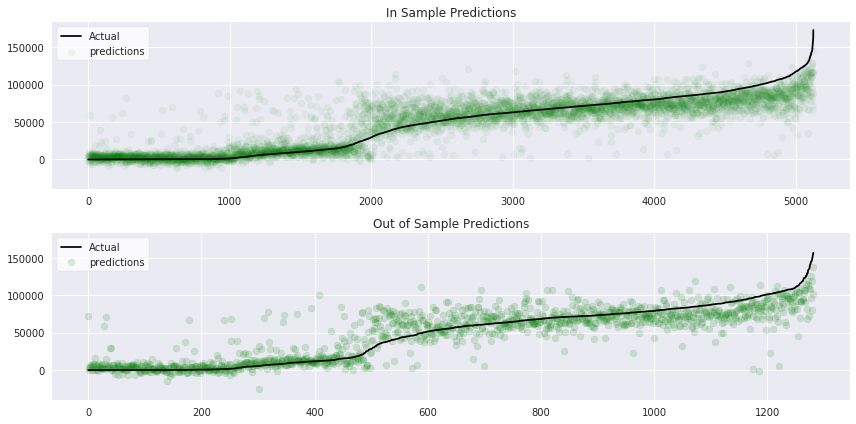

In [36]:
fig, ax = plt.subplots(2,1,figsize=(12,6), sharey=True)

ax[0].scatter(range(len(y_train_sort)), y_train_predict_sort,alpha=0.05, label='predictions', c='g')
ax[0].plot(range(len(y_train_sort)), y_train_sort.values, label='Actual',color='black')
ax[0].set_title("In Sample Predictions")
ax[0].legend()

ax[1].scatter(range(len(y_test_sort)), y_test_predict_sort,alpha=0.15, label='predictions', c='g')
ax[1].plot(range(len(y_test_sort)), y_test_sort.values, label='Actual',color='black')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()

fig.tight_layout()

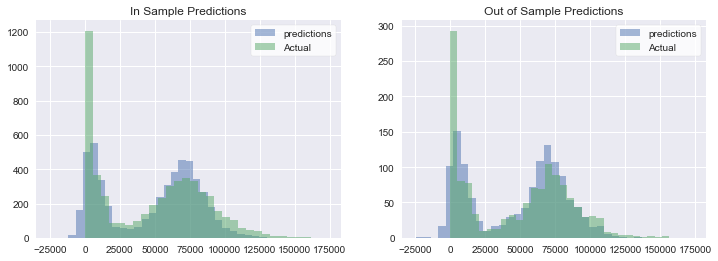

In [304]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(y_train_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train_sort.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(y_test_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test_sort.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()


### Residuals

By looking at its errors, the conclusion aligns with the plots above. Linear regression model tends to overestimate low revenue taxi and underestimate high revenue taxi. 

We hope to improve this by applying another machine-learning based model.

In [325]:
e_in_sample = y_train_predict_sort - y_train_sort
e_oos = y_test_predict_sort -  y_test_sort

Text(0.5, 0, 'Actual Revenue')

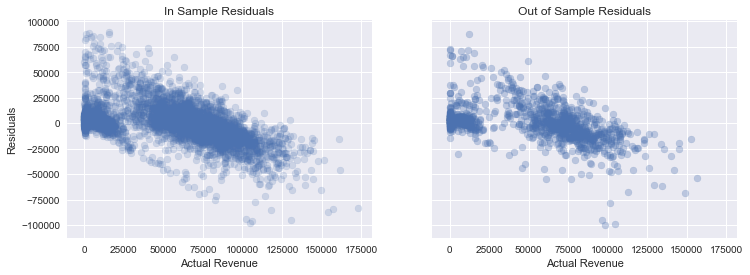

In [328]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)


ax[0].scatter(y_train_sort.values, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(y_test_sort.values,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")